## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import isnan
from matplotlib import cm

%matplotlib inline
pd.options.display.max_columns = 999
gr      = 1.618

In [11]:
fname = '../Input/data/bnb_xgb.pckl'
df = pd.read_pickle(fname)
df[(df["event"]==1515) & (df["run"]==5328)].head()
#df[(df["event"]==31) & (df["run"]==5513)].head()
#df[(df["event"]==1493) & (df["run"]==5694)].head()

,vx,vy,vz,event,subrun,run,shower_nhits,track_nhits,candidate_pdg,numu_cuts,bnbweight,reconstructed_energy,flash_PE,flash_time,category,shower_containment_q,shower_sp_profile,shower_energy,track_energy,shower_electron_score,track_muon_score,shower_muon_score,track_electron_score,track_closest_electron_score,shower_closest_electron_score,fidvol
14340,53.474838,-61.123631,379.12973,1515,30,5328,"[358.0, 23.0, 3.0]",[],12,0,-2147483648,0.379035,2554.336182,4.369375,6,1.0,1.08642,"[0.30669286743464935, 0.06984739854493756, 0.0...",[],"[0.9225577, 0.10489171]",[],"[0.010107328, 0.033692993]",[],[],"[0.86272657, 0.07798143]",True


## Try-outs without ROOT

In [9]:
fname = '../Input/Old/nue/nue_6.pckl'
#fname = '../Input/nue/nue_dev_newchr_dedx.pckl'

In [10]:
def MatchedElectronEnergy(row):
    reco_matched_lepton_E = 0
    reco_matched_lepton_E_cali = 0
    
    for pdg,E,cali in zip(*row[['matched_showers','shower_energy','shower_cali']]):
        if pdg==11:
            reco_matched_lepton_E += E
            reco_matched_lepton_E_cali += E*(cali)
    for pdg,E,cali in zip(*row[['matched_tracks','track_energy','track_cali']]):
        if pdg==11:
            reco_matched_lepton_E += E
            reco_matched_lepton_E_cali += E*(cali)
            
    return pd.Series({"reco_matched_lepton_E":reco_matched_lepton_E, "reco_matched_lepton_E_cali":reco_matched_lepton_E_cali})

def ClosestElectronDedx(row):
    if (11 not in row['matched_showers']) and (11 not in row['matched_tracks']):
        return pd.Series({'cl_e_dedx': 0, 'cl_e_dedx_cali': 0}) 
    
    cl_e_dedx=0
    cl_e_dedx_cali=0
    
    d=20 # If the closest object is further than 10cm, forget it anyway
    i = -1
    
    true_x = row["true_vx_sce"]
    true_y = row["true_vy_sce"]
    true_z = row["true_vz_sce"]
    
    if (11 in row['matched_showers']):
        sh_x_arr = row["shower_start_x"]
        sh_y_arr = row["shower_start_y"]
        sh_z_arr = row["shower_start_z"]
        sh_pdg_arr = row['matched_showers']
        sh_dedx_arr = row['shower_dedx']
        sh_dedx_avg_arr = row['shower_dedx_avg']
        sh_dedx_cali_arr = row['shower_dedx_cali']
    
        for sh_x,sh_y,sh_z,sh_pdg,sh_dedx,sh_dedx_avg,sh_dedx_cali in zip(sh_x_arr,sh_y_arr,sh_z_arr,sh_pdg_arr,sh_dedx_arr,sh_dedx_avg_arr,sh_dedx_cali_arr):
            if sh_pdg==11:
                dist = np.linalg.norm([sh_x-true_x,sh_y-true_y,sh_z-true_z])
                if dist<d:
                    d=dist
                    cl_e_dedx=sh_dedx_avg
                    cl_e_dedx_cali=sh_dedx*sh_dedx_cali
    
    if (11 in row['matched_tracks']):
        tr_x_arr = row["track_start_x"]
        tr_y_arr = row["track_start_y"]
        tr_z_arr = row["track_start_z"]
        tr_pdg_arr = row['matched_tracks']
        tr_dedx_arr = row['track_dedx']
        tr_dedx_avg_arr = row['track_dedx_avg']
        tr_dedx_cali_arr = row['track_dedx_cali']
    
        for tr_x,tr_y,tr_z,tr_pdg,tr_dedx, tr_dedx_avg, tr_dedx_cali in zip(tr_x_arr,tr_y_arr,tr_z_arr,tr_pdg_arr,tr_dedx_arr,tr_dedx_avg_arr,tr_dedx_cali_arr):
            if tr_pdg==11:
                dist = np.linalg.norm([tr_x-true_x,tr_y-true_y,tr_z-true_z])
                if dist<d:
                    d=dist
                    cl_e_dedx=tr_dedx_avg
                    cl_e_dedx_cali=tr_dedx*tr_dedx_cali
            
    return pd.Series({'cl_e_dedx': cl_e_dedx, 'cl_e_dedx_cali': cl_e_dedx_cali}) 

In [11]:
df = pd.read_pickle(fname)
print(df.columns)
df.head(5)

Index(['event', 'subrun', 'run', 'nu_pdg', 'nu_E', 'true_vx_sce',
       'true_vy_sce', 'true_vz_sce', 'distance', 'category', 'vx', 'vy', 'vz',
       'bnbweight', 'passed', 'shower_open_angle', 'shower_length',
       'shower_start_x', 'shower_start_y', 'shower_start_z', 'shower_dir_x',
       'shower_dir_y', 'shower_dir_z', 'shower_pca', 'track_start_x',
       'track_start_y', 'track_start_z', 'track_end_x', 'track_end_y',
       'track_end_z', 'track_dir_x', 'track_dir_y', 'track_dir_z', 'track_pca',
       'predict_em', 'predict_mu', 'predict_cos', 'predict_pi', 'predict_p',
       'nu_daughters_pdg', 'nu_daughters_E', 'nu_daughters_px',
       'nu_daughters_py', 'nu_daughters_pz', 'nu_daughters_endx',
       'nu_daughters_endy', 'nu_daughters_endz', 'true_shower_pdg',
       'true_shower_x_sce', 'true_shower_y_sce', 'true_shower_z_sce',
       'true_shower_depE', 'shower_daughter', 'shower_is_daughter',
       'track_daughter', 'track_is_daughter', 'shower_containment_q',
      

,event,subrun,run,nu_pdg,nu_E,true_vx_sce,true_vy_sce,true_vz_sce,distance,category,vx,vy,vz,bnbweight,passed,shower_open_angle,shower_length,shower_start_x,shower_start_y,shower_start_z,shower_dir_x,shower_dir_y,shower_dir_z,shower_pca,track_start_x,track_start_y,track_start_z,track_end_x,track_end_y,track_end_z,track_dir_x,track_dir_y,track_dir_z,track_pca,predict_em,predict_mu,predict_cos,predict_pi,predict_p,nu_daughters_pdg,nu_daughters_E,nu_daughters_px,nu_daughters_py,nu_daughters_pz,nu_daughters_endx,nu_daughters_endy,nu_daughters_endz,true_shower_pdg,true_shower_x_sce,true_shower_y_sce,true_shower_z_sce,true_shower_depE,shower_daughter,shower_is_daughter,track_daughter,track_is_daughter,shower_containment_q,shower_sp_profile,reconstructed_energy,shower_energy,shower_nhits,total_nhits,track_energy,track_nhits,shower_dedx,shower_dedx_avg,shower_dedx_hits,track_dedx,track_dedx_avg,track_dedx_hits,flash_PE,flash_time,CC_daughter_E,true_shower_endx,true_shower_endy,true_shower_endz,true_shower_tmax_x,true_shower_tmax_y,true_shower_tmax_z,matched_showers,matched_showers_energy,matched_tracks,matched_tracks_energy
0,338111,6763,1,12,4.995859,189.162140,53.705956,766.479065,0.675555,2,188.996567,54.360748,766.464539,0.433257,1,"[0.034302, 0.55664, 0.18298, 0.068726, 0.15186...","[196.5, 51.125, 81.375, 151.5, 30.828, 30.984,...","[188.38, 194.0, 189.38, 200.75, 202.75, 173.0,...","[53.625, 56.406, 62.5, 59.875, 49.281, 16.734,...","[767.5, 811.5, 775.0, 784.5, 813.5, 832.0, 767...","[-0.5835, -0.17981, -0.31567, 0.46753, 0.4458,...","[-0.056671, 0.43042, 0.63232, 0.29346, -0.8950...","[0.81006, 0.88477, -0.70752, 0.83398, -0.01274...","[0.97754, 0.82959, 0.89404, 0.95996, 0.95898, ...",[194.62],[41.688],[798.5],[215.25],[104.94],[961.0],[-0.098999],[0.32788],[0.93945],[0.99609],[0.014389],[0.46655],[0.40259],[0.072449],[0.043945],"[11, 2112, 111, 2212, 211, 2112, 2112, 311, -311]","[0.83154, 1.4023, 0.36377, 0.94678, 0.52881, 1...","[-0.48511, 0.20032, 0.063354, -0.071106, 0.082...","[-0.058044, 0.020462, 0.058807, -0.044891, 0.1...","[0.67285, 1.0215, 0.32666, -0.095825, 0.48975,...","[185.5, 185.5, 185.5, 185.5, 185.5, 185.5, 185...","[58.719, 58.719, 58.719, 58.719, 58.719, 58.71...","[766.5, 766.5, 766.5, 766.5, 766.5, 766.5, 766...",[11],[189.12],[53.719],[766.5],[830.0],"[0, 0, 0, 0, 0, 0, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0]",[0],[0],1.000000,1.544643,1.856288,"[0.496978698152, 0.131166932515, 0.31667734767...","[398.0, 117.0, 279.0, 129.0, 52.0, 38.0, 54.0,...",4194,[0.491198004233],[561.0],"[1.86524564087, 2.42362863723, 3.35934330505, ...","[2.59143324366, 4.07240914431, 4.33921970822, ...","[12.0, 15.0, 11.0, 12.0, 3.0, 6.0, 15.0, 6.0, ...",[1.44614341082],[4.35717751121],[3.0],5003.657227,4.17125,0.831447,78.385201,45.886101,915.114258,167.929108,56.599800,790.953674,"[11, 211, 211, 22, 211, 211, 22, 22, 22]","[0.831446934981, 0.528634357768, 0.50508131559...",[-211],[0.913227375941]
1,338116,6763,1,12,1.629150,103.200180,92.750435,488.355591,16.620516,2,103.934402,92.892776,504.959259,0.703084,1,[0.096497],[142.62],[104.94],[93.125],[505.0],[0.095093],[-0.54346],[0.83398],[0.89502],[104.0],[86.312],[501.25],[103.19],[78.938],[487.5],[-0.065125],[-0.38989],[-0.91846],[0.98193],[0.014778],[0.24854],[0.0023155],[0.64941],[0.085144],"[11, 2212, 2212, 2212, 2212, 2212, 2112, 2112,...","[1.2334, 0.98828, 0.94727, 0.95215, 0.96289, 1...","[0.10101, -0.094421, 0.019531, -0.16028, 0.214...","[-0.59961, 0.29443, -0.069885, -0.017853, -0.0...","[1.0732, -0.0186, 0.10785, 0.016525, 0.020035,...","[101.38, 101.38, 101.38, 101.38, 101.38, 101.3...","[96.125, 96.125, 96.125, 96.125, 96.125, 96.12...","[488.25, 488.25, 488.25, 488.25, 488.25, 488.2...",[11],[103.19],[92.75],[488.25],[1231.0],[0],[0],[0],[0],1.000000,1.245421,1.064689,[0.905611035834],[679.0],1733,[0.159078301026],[74.0],[7.17979765054],[101.692120364],[15.0],[2.071164404],[15.3911860296],[5.0],4480.976562,4.14125,1.233172,116.832542,4.211959,652.778748,104.264

In [12]:
df['category'].value_counts()/len(df.index)
#df["category"].hist()


2    0.725868
7    0.241419
1    0.032714
Name: category, dtype: float64

4.7981248

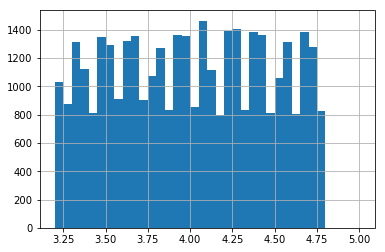

In [8]:
df[df['category']>-1]['flash_time'].hist(bins=36,range=(3.2,5.0))
min(df[df['category']>-1]['flash_time'])
max(df[df['category']>-1]['flash_time'])

In [7]:
df = pd.concat([df, df.apply(MatchedElectronEnergy,axis=1)], axis=1)

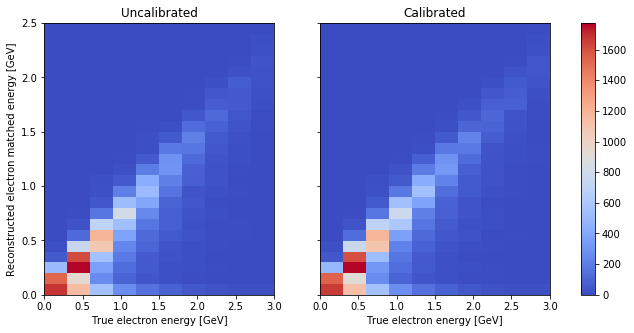

In [8]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(7*gr,5),sharey=True,sharex=True)

counts, xedges, yedges, im0 = ax[0].hist2d(df['CC_daughter_E'],df['reco_matched_lepton_E'],
                                          bins=(10,25),range=([0,3],[0,2.5]),weights=df['bnbweight'],cmap=cm.coolwarm)

counts, xedges, yedges, im1 = ax[1].hist2d(df['CC_daughter_E'],df['reco_matched_lepton_E_cali'],
                                          bins=(10,25),range=([0,3],[0,2.5]),weights=df['bnbweight'],cmap=cm.coolwarm)

plt.colorbar(im1, ax=ax)

ax[0].set_title('Uncalibrated')
ax[1].set_title('Calibrated')

ax[0].set_xlabel('True electron energy [GeV]')
ax[1].set_xlabel('True electron energy [GeV]')
ax[0].set_ylabel('Reconstructed electron matched energy [GeV]')

plt.savefig("../Output/cali2d.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)



Bin start:0.0 	end:0.3 	median:0.11 	std:0.222 	median_cali:0.12 	std_cali:0.221
Bin start:0.3 	end:0.6 	median:0.27 	std:0.217 	median_cali:0.27 	std_cali:0.216
Bin start:0.6 	end:0.9 	median:0.48 	std:0.204 	median_cali:0.48 	std_cali:0.204
Bin start:0.9 	end:1.2 	median:0.68 	std:0.196 	median_cali:0.69 	std_cali:0.194
Bin start:1.2 	end:1.5 	median:0.88 	std:0.186 	median_cali:0.89 	std_cali:0.184
Bin start:1.5 	end:1.8 	median:1.09 	std:0.178 	median_cali:1.10 	std_cali:0.175
Bin start:1.8 	end:2.1 	median:1.31 	std:0.181 	median_cali:1.32 	std_cali:0.179
Bin start:2.1 	end:2.4 	median:1.52 	std:0.176 	median_cali:1.51 	std_cali:0.173
Bin start:2.4 	end:2.7 	median:1.72 	std:0.171 	median_cali:1.72 	std_cali:0.170
Bin start:2.7 	end:3.0 	median:1.95 	std:0.163 	median_cali:1.97 	std_cali:0.158


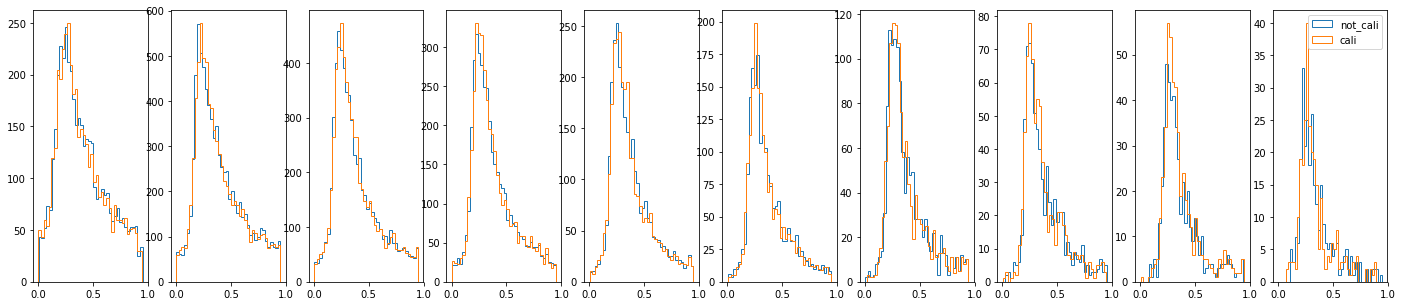

In [9]:
N = 10
fig,ax=plt.subplots(ncols=N,nrows=1,figsize=(15*gr,5),sharey=False,sharex=True)

for i in range(len(xedges)-1):
    indices = np.digitize(df['CC_daughter_E'],xedges[1:])
    
    missing = (df['CC_daughter_E'][indices==i]-df['reco_matched_lepton_E'][indices==i])/df['CC_daughter_E'][indices==i]
    missing = missing[(missing >= 0) & (missing <= .95)]
    ax[int(i)].hist(missing,bins=40,histtype='step',Fill=False,label='not_cali')
    median = np.median( df['reco_matched_lepton_E'][indices==i] )
    std = np.std( missing )
    
    missing = (df['CC_daughter_E'][indices==i]-df['reco_matched_lepton_E_cali'][indices==i])/df['CC_daughter_E'][indices==i]
    missing = missing[(missing >= 0) & (missing <= .95)]
    ax[int(i)].hist(missing,bins=40,histtype='step',Fill=False,label='cali')
    median_cali = np.median( df['reco_matched_lepton_E_cali'][indices==i] )
    std_cali = np.std( missing )
    
    print('Bin start:%.1f'%xedges[i],'\tend:%.1f'%xedges[i+1],'\tmedian:%.2f'%median,'\tstd:%.3f'%std,'\tmedian_cali:%.2f'%median_cali,'\tstd_cali:%.3f'%std_cali)

plt.legend()

In [14]:
df = pd.concat([df, df.apply(ClosestElectronDedx,axis=1)], axis=1)

/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel/__main__.py:45: RuntimeWarning: overflow encountered in double_scalars
/home/wouter/anaconda3/envs/mlenv/lib/python3.6/site-packages/ipykernel/__main__.py:62: RuntimeWarning: overflow encountered in double_scalars


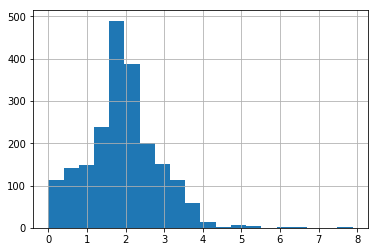

In [11]:
df[df['cl_g_dedx']>0]['cl_g_dedx'].hist(bins=20)

11.212389970326925
0.0
34765
25233


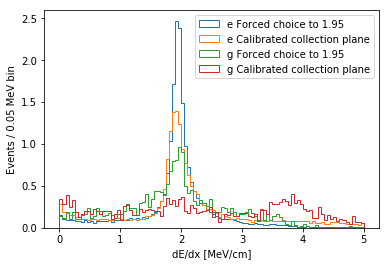

In [16]:
cl_e_dedx = df['cl_e_dedx']
cl_e_dedx_cali = df['cl_e_dedx_cali']
cl_g_dedx = df['cl_g_dedx']
cl_g_dedx_cali = df['cl_g_dedx_cali']
print(max(cl_e_dedx))
print(min(cl_e_dedx))
print(len(cl_e_dedx))
print(len(cl_e_dedx[cl_e_dedx>0]))

plt.hist(cl_e_dedx[cl_e_dedx>0],range=(0,5),bins=100,histtype='step',Fill=False,label='e Forced choice to 1.95',density=True)
plt.hist(cl_e_dedx_cali[cl_e_dedx_cali>0],range=(0,5),bins=100,histtype='step',Fill=False,label='e Calibrated collection plane',density=True)

plt.hist(cl_g_dedx[cl_g_dedx>0],range=(0,5),bins=100,histtype='step',Fill=False,label='g Forced choice to 1.95',density=True)
plt.hist(cl_g_dedx_cali[cl_g_dedx_cali>0],range=(0,5),bins=100,histtype='step',Fill=False,label='g Calibrated collection plane',density=True)
plt.legend()
plt.xlabel('dE/dx [MeV/cm]')
plt.ylabel('Events / 0.05 MeV bin')

plt.savefig("../Output/dedx_cali.png",dpi=500,
            transparant=True,
               bbox_inches='tight', 
               pad_inches=0.1)

## Try-outs with ROOT

In [3]:
from root_pandas import read_root

In [6]:
#fname= '/run/user/1000/gvfs/sftp:host=uboonegpvm02.fnal.gov,user=wvdp/uboone/data/users/wvdp/v06_26_01_12/data_bnb_b_1s0t/5284437_18/PandoraLEEAnalyzer.root'
#fname= '/run/user/1000/gvfs/sftp:host=uboonegpvm02.fnal.gov,user=wvdp/uboone/data/users/wvdp/v06_26_01_12/bnb_nue_cosmic_1s0t/4982420_111/PandoraLEEAnalyzer.root'
#fname= '/run/user/1000/gvfs/sftp:host=uboonegpvm02.fnal.gov,user=wvdp/uboone/data/users/wvdp/v06_26_01_12/cosmic_intime_1s0t/5021465_1030/PandoraLEEAnalyzer.root'
fname='../PandoraLEEAnalyzer.root'
df=read_root(fname,"wouterNueCC/pandoratree")
df=df[df['passed']==1]
df_pot = read_root(fname,"wouterNueCC/pot")

In [18]:
df[["passed","n_showers","n_tracks",
    #'track_maxangle','shower_maxangle',
    "track_is_daughter","shower_is_daughter",
    #"nu_track_ids","nu_track_daughters", "nu_shower_ids","nu_shower_daughters",
    #"true_1eX_signal",
    #"shower_fidvol_ratio","vx","vy","vz",
    "shower_spacepoint_dqdx_ratio", "track_spacepoint_dqdx_ratio","matched_showers","matched_tracks"
   ]].head(20)
#len(df.index)
#df.head(10)

,passed,n_showers,n_tracks,track_is_daughter,shower_is_daughter,shower_spacepoint_dqdx_ratio,track_spacepoint_dqdx_ratio,matched_showers,matched_tracks
0,1,0,1,[0],[],[],[0.91748],[],[-13]
2,1,0,1,[0],[],[],[0.67372],[],[13]
4,1,1,2,"[0, 0]",[0],[0.289893],"[0.883584, 0.733518]",[-2147483648],"[13, 2212]"
5,1,0,3,"[0, 0, 0]",[],[],"[0.837468, 0.833833, 0.659158]",[],"[13, 2212, 2212]"
10,1,0,1,[0],[],[],[0.884689],[],[-13]
11,1,0,1,[0],[],[],[1.05952],[],[13]
12,1,0,1,[0],[],[],[1.38056],[],[13]
13,1,0,3,"[0, 0, 0]",[],[],"[1.16809, 0.793121, 0.650694]",[],"[13, -13, 2212]"
16,1,0,2,"[0, 0]",[],[],"[0.650445, 0.0]",[],"[13, 2212]"
17,1,0,1,[0],[],[],[0.910412],[],[-13]


In [28]:
for index, row in df.iterrows():
    for i,z,y,x in zip(range(row['n_showers']),*row[['shower_start_z','shower_start_y','shower_start_x']]):
        print(i,x,y,z)
    break
    
print (row[['track_maxangle','track_maxangle','track_start_x']])

0 125.455062866 -74.0278015137 329.600006104
track_start_z     [311.717285156]
track_start_y    [-65.5857315063]
track_start_x     [64.4975128174]
Name: 6, dtype: object


In [29]:
df.columns.values

array(['category', 'reconstructed_energy', 'n_tracks', 'n_showers', 'ccnc',
       'qsqr', 'theta', 'vx', 'vy', 'vz', 'true_vx', 'true_vy', 'true_vz',
       'true_shower_x_sce', 'true_shower_y_sce', 'true_shower_z_sce',
       'true_shower_pdg', 'true_shower_depE', 'true_vx_sce', 'true_vy_sce',
       'true_vz_sce', 'nu_E', 'passed', 'numu_passed', 'numu_cuts',
       'n_candidates', 'n_true_nu', 'distance', 'n_matched',
       'nu_matched_tracks', 'nu_matched_showers', 'nu_daughters_pdg',
       'nu_daughters_E', 'nu_daughters_vx', 'nu_daughters_vy',
       'nu_daughters_vz', 'nu_daughters_endx', 'nu_daughters_endy',
       'nu_daughters_endz', 'nu_daughters_px', 'nu_daughters_py',
       'nu_daughters_pz', 'nu_track_ids', 'nu_shower_ids',
       'nu_shower_daughters', 'nu_track_daughters', 'event', 'run',
       'subrun', 'bnbweight', 'chosen_candidate', 'candidate_pdg',
       'n_primaries', 'primary_indexes', 'number_tracks', 'number_showers',
       'flash_time', 'flash_PE', 'fla

In [30]:
df[["event",'category','passed','shower_dQdx_cali','shower_energy_cali','shower_energy_hits','shower_nhits_cluster','shower_nhits_spacepoint','shower_start_x', 'shower_start_y',
       'shower_start_z','vx', 'vy', 'vz','matched_showers','matched_showers_energy','matched_tracks']].head(10)

,event,category,passed,shower_dQdx_cali,shower_energy_cali,shower_energy_hits,shower_nhits_cluster,shower_nhits_spacepoint,shower_start_x,shower_start_y,shower_start_z,vx,vy,vz,matched_showers,matched_showers_energy,matched_tracks
6,938668,1,1,"[[0.985972, 1.01287, 0.994939]]","[[0.986814, 1.00943, 0.991754]]","[[0.0252997200127, 0.0210222971672, 0.02548861...","[[25, 11, 27]]","[[18, 10, 17]]",[125.455062866],[-74.0278015137],[329.600006104],64.536118,-65.527115,311.794708,[13],[14.1786950991],[-13]
117,1632019,1,1,"[[0.948668, 0.986689, 1.09394], [0.930292, 0.9...","[[0.95606, 0.968622, 0.98579], [0.0, 0.967769,...","[[0.197982927181, 0.347515605211, 0.3415984891...","[[156, 306, 123], [0, 89, 19], [26, 29, 23], [...","[[118, 230, 59], [0, 61, 14], [22, 18, 22], [2...","[218.107574463, 216.014755249, 19.8891048431, ...","[66.8941650391, 67.4581298828, 51.5458831787, ...","[105.849998474, 99.4391860962, 388.700012207, ...",215.689117,69.300934,96.914925,"[2112, 2112, 22, 2112]","[3.03644491169, 3.03644491169, 0.313284693993,...",[]
145,1632489,1,1,"[[0.96605, 0.973902, 1.06596]]","[[0.0, 1.04887, 1.14819]]","[[0.0, 0.0142110551687, 0.0531131386059]]","[[0, 23, 8]]","[[0, 2, 3]]",[224.033538818],[109.084899902],[285.27935791],223.954224,108.756142,285.396027,[13],[9.26507882274],[-13]


In [ ]:
dfplot=df

In [ ]:
ratio=[]
for index, row in dfplot.iterrows():
    if len(row['shower_nhits_spacepoint'])>0:
        ratio.extend(np.hstack(row['shower_nhits_spacepoint'])/np.hstack(row['shower_nhits_cluster']))
ratio = [value for value in ratio if not isnan(value)]
print(len(ratio))

In [ ]:
plt.hist(ratio,bins=50,range=(0.1,1.05))